**基本介绍**

RNN, Recurrent Neural Network，循环神经网络，是非常典型的处理时序数据的网络模型。

RNN是增加了时间步概念的全连接网络。RNN在每个时刻$t$均会接收两个输入，一个是当前时刻的单词$x_t$，一个是来自上一个时刻的输出$h_{t-1}$，经过计算后产生当前时刻的输出$h_t$。即：
$$h_t = tanh(Wx_t+Hh_{t-1}+b)$$

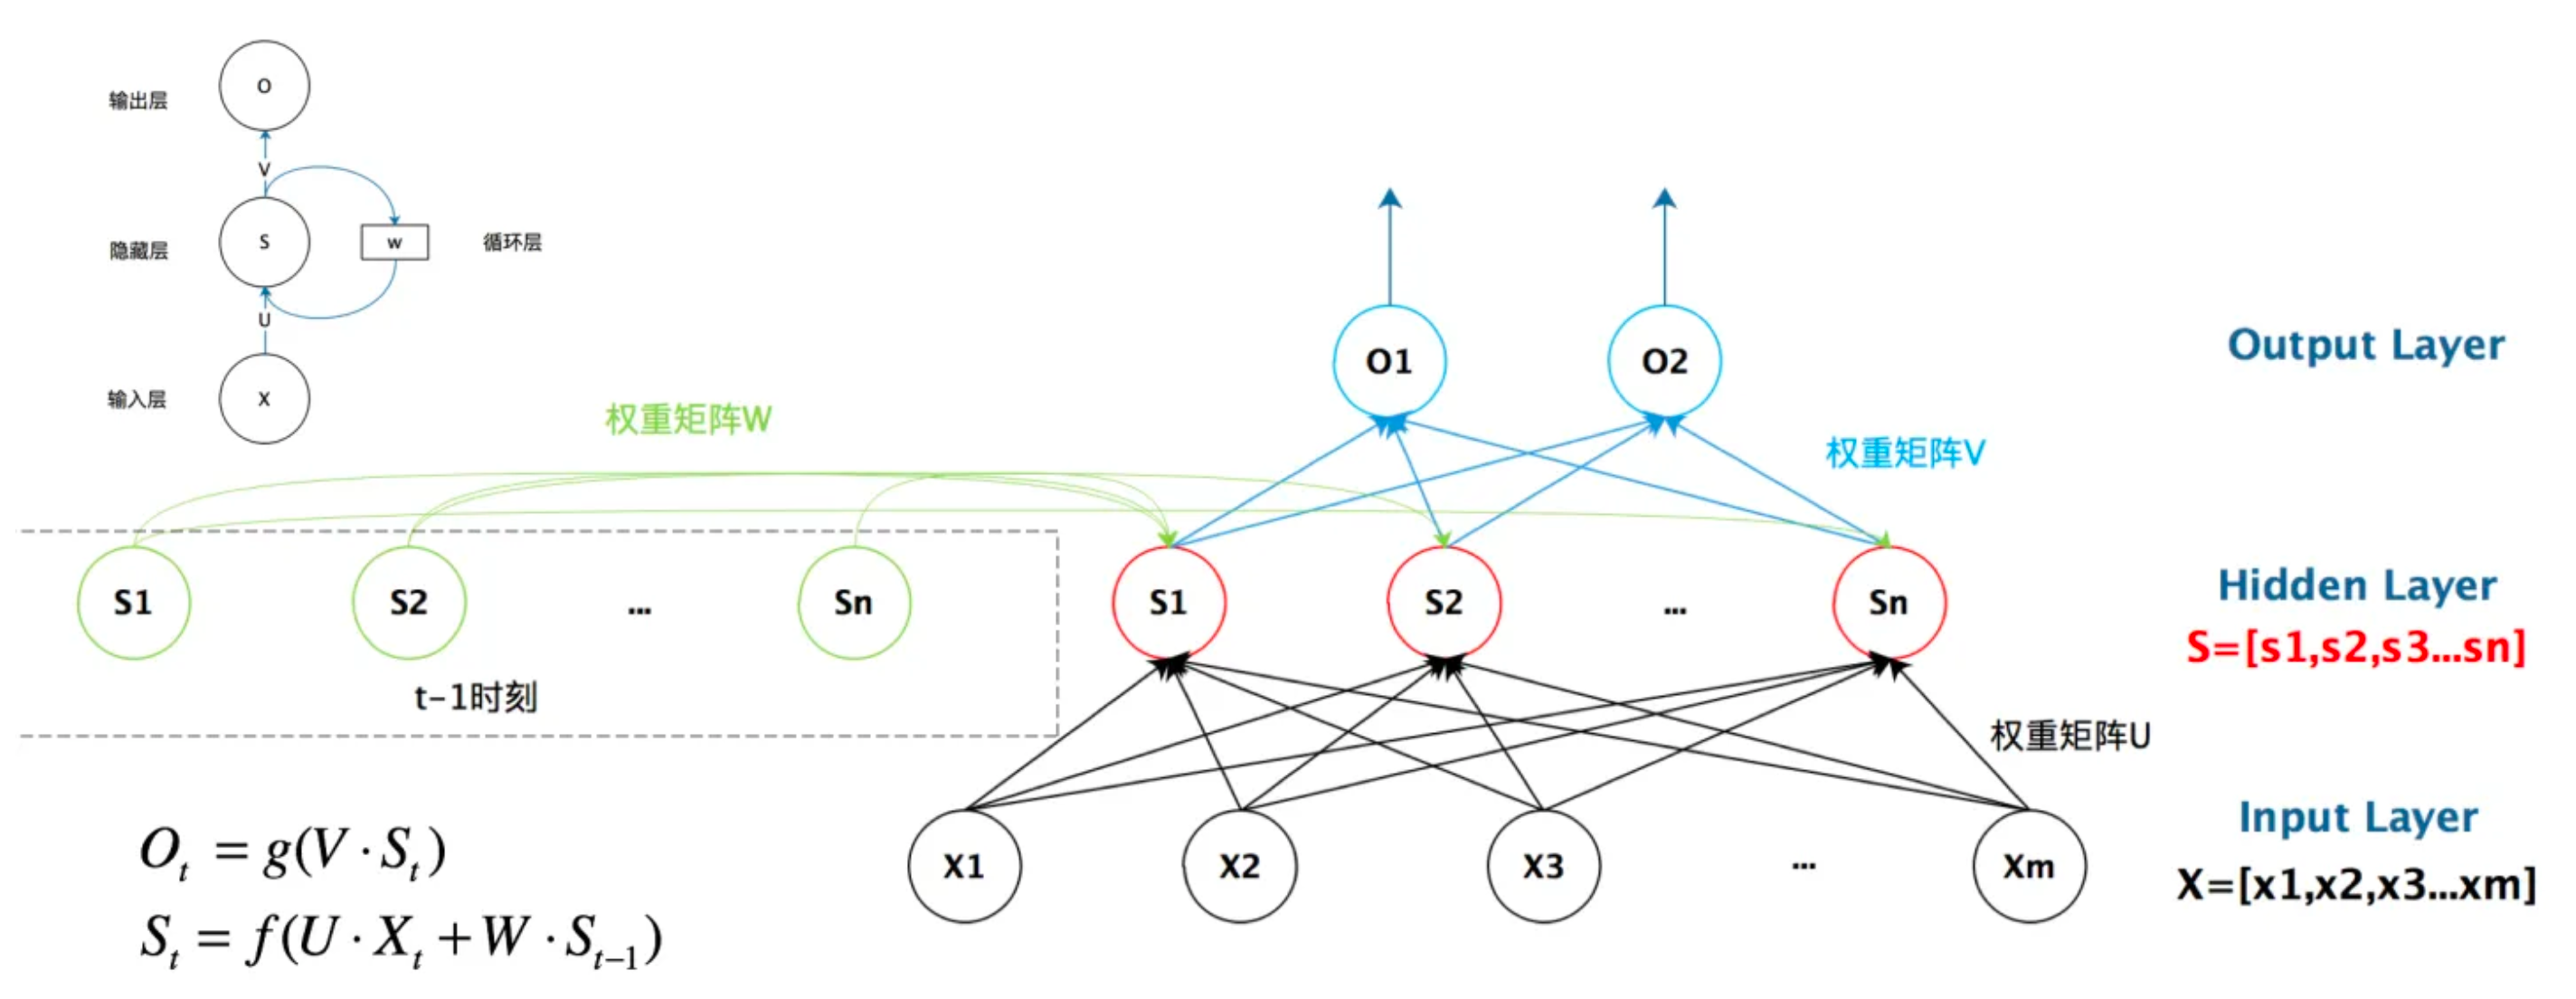

但RNN存在的问题如下，即缺少长距离依赖处理能力，无法处理长文本。
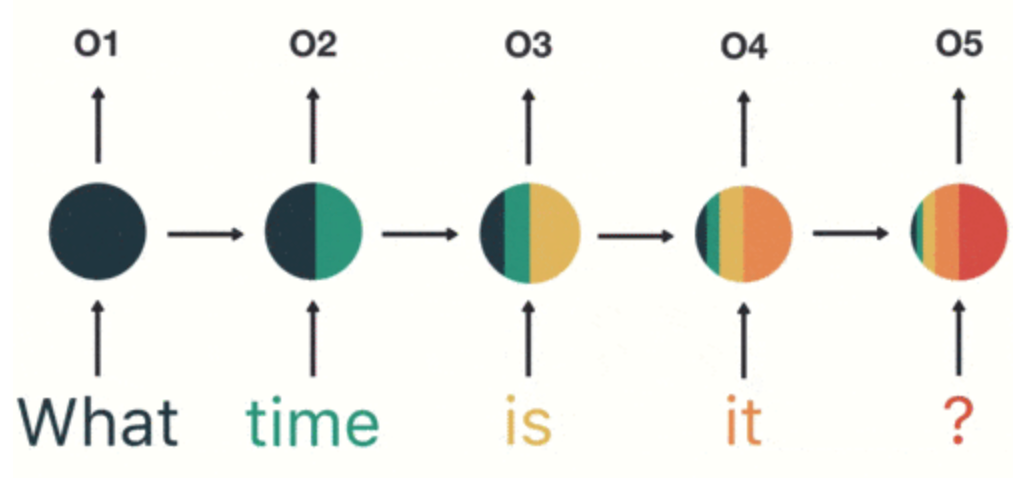

为了提出了LSTM及其变体GRU，使用门控机制进行改善：
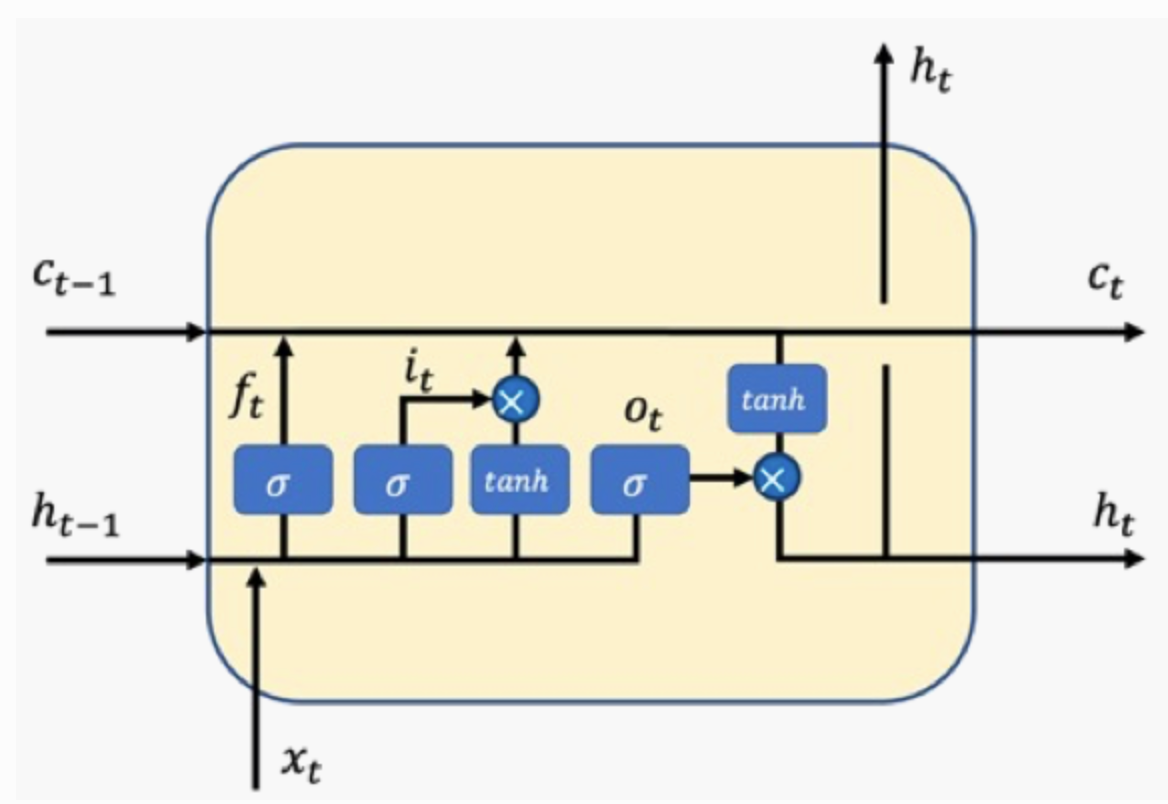

进一步地，单个LSTM Cell可以表示为：
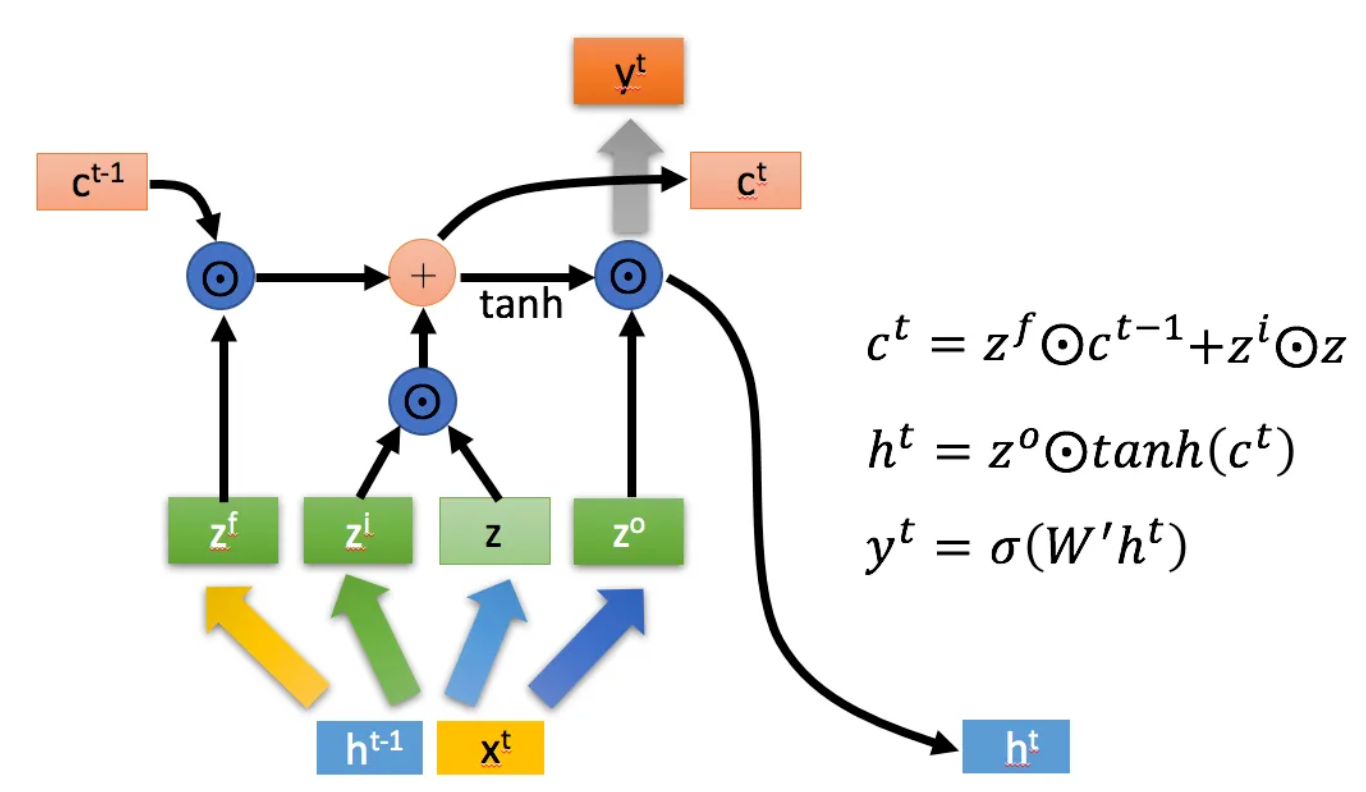

其中，

状态向量$c_{t}$，是LSTM的核心部分，它控制着整个LSTM单元的状态或者记忆，一般叫做单元状态(cell state)。它会根据每个时刻的输入进行更新，从而实时保持LSTM单元的记忆。

隐状态向量$h_t$，是当前LSTM单元对外的输出状态。

输入门$i_t$，控制当前时刻的输入信息$x_t$需要向状态向量$c_{t}$中注入哪些信息。

$$i_t = sigmoid(\begin{bmatrix}W_i & H_i\end{bmatrix}\begin{bmatrix}x_t \\ h_{t-1}\end{bmatrix})$$

遗忘门$f_t$，控制前一时刻的状态向量$c_{t-1}$需要被屏蔽/遗忘哪些信息。
$$f_t = sigmoid(\begin{bmatrix}W_f & H_f\end{bmatrix}\begin{bmatrix}x_t \\ h_{t-1}\end{bmatrix})$$

输出门$o_t$，控制当前时刻的状态向量$c_{t}$需要对外输出哪些信息，最终输出的信息即为$h_t$。
$$o_t = sigmoid(\begin{bmatrix}W_o & H_o\end{bmatrix}\begin{bmatrix}x_t \\ h_{t-1}\end{bmatrix})$$

基本的输出与RNN相同，即
$$z = tanh(Wx_t+Hh_{t-1}+b)$$

但LSTM真正的输出$h_t$，是由各个门控处理$z$和$c_{t-1}$得到的。
$$
c_t = c_{t-1} \odot f_t+i_t \odot z\\
h_t = tanh(c_t)\odot o_t
y_t = sigmoid(W'h_t)
$$

In [109]:
import tensorflow as tf

# 定义 LSTM cell 类
class LSTMCell(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LSTMCell, self).__init__()
        self.units = units
        self.forget_gate = tf.keras.layers.Dense(units, activation='sigmoid')
        self.input_gate = tf.keras.layers.Dense(units, activation='sigmoid')
        self.candidate = tf.keras.layers.Dense(units, activation='tanh')
        self.output_gate = tf.keras.layers.Dense(units, activation='sigmoid')
        self.state = None

    def call(self, inputs, states):
        if states is None:
            # 初始化状态
            self.state = tf.zeros([inputs.shape[0], self.units*2])
            h, c = tf.split(self.state, num_or_size_splits=2, axis=1)
            states = (h, c)
        else:
            h, c = states
        
        # 计算遗忘门、输入门、候选状态和输出门
        forget = self.forget_gate(tf.concat([inputs, h], axis=1))
        input_ = self.input_gate(tf.concat([inputs, h], axis=1))
        candidate = self.candidate(tf.concat([inputs, h], axis=1))
        output = self.output_gate(tf.concat([inputs, h], axis=1))

        # 更新状态
        new_c = forget * c + input_ * candidate
        new_h = output * tf.tanh(new_c)
        self.state = tf.concat([new_h, new_c], axis=1)
        return new_h, new_c

    
class LSTM(tf.keras.layers.Layer):
    def __init__(self, units, return_sequences=False):
        super().__init__()
        self.units = units
        self.return_sequences = return_sequences
        self.cell = LSTMCell(units)
        
    def call(self, inputs):
        # 初始化隐藏状态和细胞状态
        self.h = tf.zeros((inputs.shape[0], self.units))
        self.c = tf.zeros((inputs.shape[0], self.units))
        
        # 存储所有时间步的隐藏状态
        h_list = []
        
        # 遍历所有时间步
        for t in range(inputs.shape[1]):
            # 取出当前时间步的输入
            x = inputs[:, t, :]            
            # 计算当前时间步的隐藏状态和细胞状态
            self.h, self.c = self.cell(x, (self.h, self.c))
            # 将隐藏状态添加到列表中
            h_list.append(self.h)
        
        # 如果指定返回所有时间步的隐藏状态，则返回一个序列
        if self.return_sequences:
            print(len(h_list), h_list[0].shape, h_list[1].shape)
            return tf.stack(h_list, axis=1)
        
        # 否则只返回最后一个时间步的隐藏状态
        return self.h

In [112]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# 载入 MNIST 数据集
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, x_test.shape)
# 归一化数据
x_train, x_test = x_train / 255.0, x_test / 255.0

# 定义超参数
units = 128
epochs = 2
batch_size = 32

# 定义LSTM模型
model = tf.keras.models.Sequential([
    LSTM(units),
    tf.keras.layers.Dense(10, activation='softmax')
])

# 编译模型
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 训练模型
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)

# 测试模型
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)


(60000, 28, 28) (10000, 28, 28)


TypeError: fit() got an unexpected keyword argument 'drop_remainder'

**使用LSTM+CRF做命名实体识别**

LSTM的作用是将上下文特征学习出来，做CRF的emission score。

CRF的输入是emission score，发射分数即状态分数，来自BiLSTM的输出。然后利用转移分数，是一个待学习的随机初始化的特征矩阵，得到最终的观测序列。

CRF的损失函数由两部分组成，真实路径分数和所有路径的总分数，且真实路径分数是所有路径中最高的。

而$分数=发射分数+转移分数$

**LSTM+CRF进行命名实体识别NER，可以掌握的点：**

#1、如何利用人民日报等已经标注好的数据，进行目标NER(LOC、PER等)数据处理
#2、如何构建CRF层，即tf2的实现，以及损失函数的构建
#3、如何利用BiLSTM+CRF进行预测，即分成两步：sub_model得到emmit_probs，再利用transition得到观测概率

In [54]:
# LSTM+CRF
# https://www.cnblogs.com/huanghaocs/p/14673020.html

# 数据预处理:
#    1. 将原始文本中，连续的词性相同的进行词性合并，比如姓名、日期等
#    2. 使用BMEO标注对句子中的词进行标注，B-X 该字是词首、M-X是词中，E-X词尾，O该字不属于任何标签，即单字

import os
import re
import collections


class RenMinDailyPreProcess:
	def __init__(self, src_file_path, tmp_file_path, tgt_file_path, vocab_file_path, label_file_path, labels=None):
		'''

		param labels: {u't': u'T', u'nr': u'PER', u'ns': u'ORG', u'nt': u'LOC'}
		'''
		self.src_file_path = src_file_path
		self.tmp_file_path = tmp_file_path
		self.tgt_file_path = tgt_file_path
		self.vocab_file_path = vocab_file_path
		self.maps = {u't': u'T', u'nr': u'PER', u'ns': u'ORG', u'nt': u'LOC'} if labels is None else labels
		self.label_file_path = label_file_path
	
	def convert_start(self):
		
		if (not os.path.exists(self.src_file_path)):
			raise IOError("SRC %s NOT FOUND" % self.src_file_path)
		
		if not os.path.exists(self.tmp_file_path):
			self._convert_src_tmp(self.src_file_path, self.tmp_file_path)
		
		if not os.path.exists(self.tgt_file_path):
			self._convert_tmp_tgt(self.tmp_file_path, self.tgt_file_path)
	
	def _convert_src_tmp(self, src_file_path, tmp_file_path):
		'''
		语料预处理
		'''
		print('Start to Convert SRC FILE to TMP FILE')
		lines = self.read_corpus_from_file(self.src_file_path)
		new_lines = []
		for line in lines:
			line = line.strip()
			if "" == line:
				continue
			words = line.split(u'  ')
			pro_words = self.process_t(words)
			pro_words = self.process_nr(pro_words)
			pro_words = self.process_k(pro_words)
			if len(pro_words) > 1:
				new_lines.append('  '.join(pro_words[1:]))
		self.write_corpus_to_file(data='\n'.join(new_lines), file_path=self.tmp_file_path)
		print('DONE')
	
	def read_corpus_from_file(self, file_path):
		"""读取语料"""
		f = open(file_path, 'r', encoding='utf-8')
		lines = f.readlines()
		f.close()
		return lines
	
	def write_corpus_to_file(self, data, file_path):
		"""写语料"""
		with open(file_path, 'w') as fw:
			fw.write(data)
	
	def q_to_b(self, q_str):
		"""全角转半角"""
		b_str = ""
		for uchar in q_str:
			inside_code = ord(uchar)
			if inside_code == 12288:  # 全角空格直接转换
				inside_code = 32
			elif 65374 >= inside_code >= 65281:  # 全角字符（除空格）根据关系转化
				inside_code -= 65248
			b_str += chr(inside_code)
		return b_str
	
	def b_to_q(self, b_str):
		"""半角转全角"""
		q_str = ""
		for uchar in b_str:
			inside_code = ord(uchar)
			if inside_code == 32:  # 半角空格直接转化
				inside_code = 12288
			elif 126 >= inside_code >= 32:  # 半角字符（除空格）根据关系转化
				inside_code += 65248
			q_str += chr(inside_code)
		return q_str
	
	def process_k(self, words):
		"""处理大粒度分词,合并语料库中括号中的大粒度分词,类似：[国家/n  环保局/n]nt """
		pro_words = []
		index = 0
		temp = u''
		while True:
			word = words[index] if index < len(words) else u''
			if u'[' in word:
				temp += re.sub(pattern=u'/[a-zA-Z]*', repl=u'', string=word.replace(u'[', u''))
			elif u']' in word:
				w = word.split(u']')
				temp += re.sub(pattern=u'/[a-zA-Z]*', repl=u'', string=w[0])
				pro_words.append(temp + u'/' + w[1])
				temp = u''
			elif temp:
				temp += re.sub(pattern=u'/[a-zA-Z]*', repl=u'', string=word)
			elif word:
				pro_words.append(word)
			else:
				break
			index += 1
		return pro_words
	
	def process_nr(self, words):
		""" 处理姓名，合并语料库分开标注的姓和名，类似：温/nr  家宝/nr"""
		pro_words = []
		index = 0
		while True:
			word = words[index] if index < len(words) else u''
			if u'/nr' in word:
				next_index = index + 1
				if next_index < len(words) and u'/nr' in words[next_index]:
					pro_words.append(word.replace(u'/nr', u'') + words[next_index])
					index = next_index
				else:
					pro_words.append(word)
			elif word:
				pro_words.append(word)
			else:
				break
			index += 1
		return pro_words
	
	def process_t(self, words):
		"""处理时间,合并语料库分开标注的时间词，类似： （/w  一九九七年/t  十二月/t  三十一日/t  ）/w   """
		pro_words = []
		index = 0
		temp = u''
		while True:
			word = words[index] if index < len(words) else u''
			if u'/t' in word:
				temp = temp.replace(u'/t', u'') + word
			elif temp:
				pro_words.append(temp)
				pro_words.append(word)
				temp = u''
			elif word:
				pro_words.append(word)
			else:
				break
			index += 1
		return pro_words
	
	def _convert_tmp_tgt(self, tmp_file_path, tgt_file_path):
		'''
		对上面预处理后的文本，采用BMEO进行标注
		'''
		print('Start to Convert TMP FILE to TGT FILE')
		lines = self.read_corpus_from_file(tmp_file_path)
		new_lines = []
		
		for line in lines:
			# 标注
			line = line.strip()
			try:
				if "" == line:
					continue
				newline = self._perform_tag(line)
				
				# 拆分成子句
				sentences = self._split_line_sentences(newline)
				new_lines.extend(sentences)
			except:
				print(line)
		
		# 将标注子句拆分成字列表和对应的标注列表
		print('\t Start _convert_sentence_to_lists')
		datas, all_words, all_tags = self._convert_sentence_to_lists(new_lines)
		print('\tDONE')
		# 保存训练数据
		self.write_corpus_to_file(data='\n'.join(datas), file_path=tgt_file_path)
		print('DONE')
		
		# 保存字典
		word_count = collections.Counter(all_words).most_common()
		word2id = {word: i for i, (word, _) in enumerate(word_count, 1)}
		word2id["PAD"] = 0
		word2id["UNK"] = len(word2id)
		
		with open(self.vocab_file_path, "w") as fw:
			for word, index in word2id.items():
				fw.write(word + "\t" + str(index) + "\n")
	
		# 保存所有标签
		with open(self.label_file_path, 'w') as fw:
			for index, tag in enumerate(all_tags):
				fw.write(tag + "\t" + str(index) + "\n")
	
	def _perform_tag(self, line):
		'''
		对nr、ns、nt进行标注
		'''
		items = line.strip().split('  ')
		new_items = []
		for item in items:
			if item == '':
				continue
			word, tag = item.split('/')
			
			if tag == 'nr' or tag == 'ns' or tag == 'nt':
				new_items.append(word[0] + "/B_" + self.maps.get(tag, tag))
				for char in word[1:len(word) - 1]:
					if char != ' ':
						new_items.append(char + "/M_" + self.maps.get(tag, tag))
				new_items.append(word[-1] + "/E_" + self.maps.get(tag, tag))
			else:
				for wor in word:
					new_items.append(wor + "/O")
		
		return "  ".join(new_items)
	
	def _split_line_sentences(self, line):
		'''
		将一整行根据标点拆分成多个子句
		'''
		sentences = re.split('[，。！？、‘’“”：]/[O]', line)
		res = []
		for sentence in sentences:
			if "" != sentence and sentence != "  ":
				res.append(sentence.strip())
		
		return res
	
	def _convert_sentence_to_lists(self, sentences):
		all_words = []
		all_tags = set()
		
		datas = []
		for line in sentences:
			try:
				line_data = []
				items = line.split("  ")
				
				flag = False
				for item in items:
					word, tag = item.split("/")
					all_words.append(word)
					all_tags.add(tag)
					line_data.append(word + "\t" + tag)
					
					if tag != 'O':
						flag = True
				if flag:
					line_data[-1] += "\n"
					datas.extend(line_data)
			except:
				print(line)
		
		return datas, all_words, all_tags

base_path = "/Users/wangjie/JupyterNotebook/FollowRumorLi"

daily_process = RenMinDailyPreProcess(
	base_path + '/DataSet/people-2014/crf_199801.txt',
	base_path + '/DataSet/people-2014/tmp.txt',
	base_path + '/DataSet/people-2014/crf_pos_data.txt',
	base_path + '/DataSet/people-2014/vocab.txt',
	base_path + '/DataSet/people-2014/label.txt')

daily_process.convert_start()

# seq2seq翻译
print("s")

Start to Convert SRC FILE to TMP FILE
DONE
Start to Convert TMP FILE to TGT FILE
	 Start _convert_sentence_to_lists
	DONE
DONE
s


In [124]:
import numpy as np
from tensorflow import keras

MAX_LEN = 50
VOCAB_SIZE = len(word2idx)
CLASS_NUMS = len(label2idx)
# 建模
# 加载词典、label
label2idx = {
    "O": 0,
    "B_LOC": 1,
    "M_LOC": 2,
    "E_LOC": 3,
    "B_ORG": 4,
    "M_ORG": 5,
    "E_ORG": 6,
    "B_PER": 7,
    "M_PER": 8,
    "E_PER": 9
}
idx2label = {idx: label for label, idx in label2idx.items()}
    
word2idx = dict()
idx2word = dict()
with open("../DataSet/people-2014/vocab.txt", "r") as fr:
    for line in fr:
        word, idx = line.strip().split("\t")
        word2idx[word] = idx
        idx2word[idx] = word
        
# 加载数据集
def read_corpus_data(corpus_path, word2idx, label2idx):
    datas, labels = [], []
    with open(corpus_path, "r") as fr:
        lines = fr.readlines()
    
    sent_, tag_ = [], []
    for line in lines:
        if line != '\n':
            char, label = line.strip().split()
            sent_.append(char)
            tag_.append(label)
        else:
            sent_ids = [word2idx[char] if char in word2idx else word2idx['UNK'] for char in sent_]
            tag_ids = [label2idx[label] if label in label2idx else 0 for label in tag_]
            datas.append(sent_ids[:min(MAX_LEN, len(sent_ids))])
            labels.append(tag_ids[:min(MAX_LEN, len(tag_ids))])
            sent_, tag_ = [], []
    return datas, labels

train_x, train_y = read_corpus_data("../DataSet/people-2014/crf_pos_data.txt", word2idx, label2idx)

# 填充

train_datas = tf.keras.preprocessing.sequence.pad_sequences(train_x, maxlen=MAX_LEN, padding='post')
train_seq_lens = np.array([len(data) for data in train_x])
labels = keras.preprocessing.sequence.pad_sequences(train_y, maxlen=MAX_LEN, padding='post')
train_labels = keras.utils.to_categorical(labels, CLASS_NUMS)


In [125]:
train_datas.shape, train_seq_lens.shape, train_labels.shape, labels.shape

((38114, 50), (38114,), (38114, 50, 10), (38114, 50))

In [190]:
# 模型搭建
import tensorflow as tf
import tensorflow_addons as tfa

class CRF(tf.keras.layers.Layer):
    def __init__(self, label_size, name=None):
        super().__init__(name=name)
        self.trans_params = tf.Variable(
            tf.random.uniform(shape=(label_size, label_size)), name="transition")
    
    def call(self, inputs, labels, seq_lens):
        tf.print(seq_lens.shape)
        log_likelihood, self.trans_params = tfa.text.crf_log_likelihood(
                                                inputs, labels, seq_lens,
                                                transition_params=self.trans_params)
        loss = tf.reduce_sum(-log_likelihood)
        return loss

In [184]:
# 训练
EPOCHS = 1
BATCH_SIZE = 64
EMBED_DIM = 128
LSTM_UNITS = 64

inputs = tf.keras.layers.Input(shape=(MAX_LEN,), name='input_ids', dtype='int32')
targets = tf.keras.layers.Input(shape=(MAX_LEN,), name='target_ids', dtype='int32')
seq_lens = tf.keras.layers.Input(shape=(), name='input_lens', dtype='int32')

x = tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, mask_zero=True)(inputs)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_UNITS, return_sequences=True))(x)
logits = tf.keras.layers.Dense(CLASS_NUMS, name="emmit_dense")(x)
loss = CRF(label_size=CLASS_NUMS, name="crf")(logits, targets, seq_lens)

model = tf.keras.models.Model(inputs=[inputs, targets, seq_lens], outputs=loss)

print(model.summary())

class CustomLoss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        loss, pred = y_pred
        return loss
    
model.compile(loss=lambda y_true, y_pred: y_pred, optimizer='adam')

model.fit(x=[train_datas, labels, train_seq_lens], y=labels, 
         batch_size=BATCH_SIZE, epochs=EPOCHS)


Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_27 (Embedding)        (None, 50, 128)      599296      input_ids[0][0]                  
__________________________________________________________________________________________________
bidirectional_27 (Bidirectional (None, 50, 128)      98816       embedding_27[0][0]               
__________________________________________________________________________________________________
emmit_dense (Dense)             (None, 50, 10)       1290        bidirectional_27[0][0]           
___________________________________________________________________________________________

100/596 [====>.........................] - ETA: 28s - loss: 1185.9823TensorShape([None])
TensorShape([None])
161/596 [=======>......................] - ETA: 25s - loss: 1033.3180TensorShape([None])


254/596 [===========>..................] - ETA: 20s - loss: 839.1870TensorShape([None])


347/596 [================>.............] - ETA: 14s - loss: 707.4616TensorShape([None])


440/596 [=====================>........] - ETA: 9s - loss: 617.2127TensorShape([None])


534/596 [=========================>....] - ETA: 3s - loss: 549.8362TensorShape([None])


596/596 [==============================] - 42s 60ms/step - loss: 514.4863


In [192]:
# 提取转移矩阵参数
trans_params = model.get_layer('crf').get_weights()[0]

# 获得BiLSTM的输出logits
sub_model = tf.keras.models.Model(inputs=model.get_layer('input_ids').input,
                        outputs=model.get_layer('emmit_dense').output)

def predict(model, inputs, input_lens):
    logits = sub_model.predict(inputs)
    # 获取CRF层的转移矩阵
    # crf_decode：viterbi解码获得结果
    pred_seq, viterbi_score = tfa.text.crf_decode(logits, trans_params, input_lens)
    return pred_seq

def get_valid_nertag(input_data, result_tags):
    result_words = []
    start, end =0, 1 # 实体开始结束位置标识
    tag_label = "O" # 实体类型标识
    for i, tag in enumerate(result_tags):
        if tag.startswith("B"):
            if tag_label != "O": # 当前实体tag之前有其他实体
                result_words.append((input_data[start: end], tag_label)) # 获取实体
            tag_label = tag.split("_")[1] # 获取当前实体类型
            start, end = i, i+1 # 开始和结束位置变更
        elif tag.startswith("M"):
            temp_label = tag.split("_")[1]
            if temp_label == tag_label: # 当前实体tag是之前实体的一部分
                end += 1 # 结束位置end扩展
        elif tag.startswith("E"):
            temp_label = tag.split("_")[1]
            if temp_label == tag_label: # 当前实体tag是之前实体的一部分
                end += 1 # 结束位置end扩展
            result_words.append((input_data[start: end], tag_label))
        else:
            tag_label = "O"
            start, end = i, i+1 # 开始和结束位置变更
    if tag_label != "O": # 最后结尾还有实体
        result_words.append((input_data[start: end], tag_label)) # 获取结尾的实体
    return result_words


In [193]:
sentence = "中共中央总书记习近平同志"
sent_chars = list(sentence)
sent2id = [int(word2idx[word]) if word in word2idx else int(word2idx['UNK']) for word in sent_chars]
sent2id_new = np.array([sent2id[:MAX_LEN] + [0] * (MAX_LEN-len(sent2id))])
test_lens = np.array([len(sent2id[:MAX_LEN])])
sent2id_new, sent2id_new.shape, test_lens

(array([[  5, 215,   5, 338, 124, 254, 103, 631, 286, 128,  66, 273,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]]),
 (1, 50),
 array([12]))

In [194]:
pred_seq = predict(model, sent2id_new, test_lens)
print(pred_seq)

get_valid_nertag(sentence, [idx2label[tag] for tag in pred_seq[0].numpy().tolist()])

tf.Tensor(
[[1 2 2 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 50), dtype=int32)


[('中共中央', 'LOC')]

**基于RNN的seq2seq做机器翻译**

参考：https://www.tensorflow.org/tutorials/text/nmt_with_attention?hl=zh-cn#翻译

可以掌握的点：

#1、Seq2Seq做翻译的架构，encoder+decoder。其中，

    encoder的输入为待翻译的句子，输出为hidden和各时间步的输出，即为句子的编码表示；

    decoder的输入包含三项，分别是上一个时间步的字、上一个时间步的context(hidden)，以及encoder各时间步的输出。decoder是vocab_size大小的多分类。

    需要说明的是，因为需要使用attention，所以才有encoder的各个时间步的输出，若不用，则直接context即可，decoder也是如此。

#2、seq2seq翻译的流程：inputs -> encoder -> context(hidden) && step_output -> decoder -> pred_word1 -> pred_word1 -> ... -> end/max_length -> total_pred_words
#3、Teacher Forcing、Attention组件
#4、损失函数中，使用mask遮盖住padding部分。

In [242]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import unicodedata
import re
import os
import io

# 处理数据

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w = w.rstrip().strip()
    
    w = '<start> ' + w + ' <end>'
    
    return w

def create_dataset(path, num_examples):
    '''
    去除重音符号、清理句子、返回句子对[ENG, SPA]，并使用zip(*list)进行解压缩
    '''
    lines = io.open(path, encoding='utf-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]] for l in lines[:num_examples]]
    
    return zip(*word_pairs)

def max_length(tensor):
    return max(len(t) for t in tensor)

def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

def load_dataset(path, num_examples=None):
    '''
    加载句子对，创建tokenizer，得到数字tensor
    '''
    targ_lang, inp_lang = create_dataset(path, num_examples)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer



In [243]:
path_to_file = "../DataSet/spa-eng/spa.txt"
num_examples = 30000
input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer = load_dataset(path_to_file, num_examples)

# 计算目标张量的最大长度
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

# 切割
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
print(len(input_tensor_train), len(target_tensor_val))

24000 6000


In [246]:
# 创建一个数据集
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = BUFFER_SIZE // BATCH_SIZE
embedding_dim = 64
units = 128
vocab_inp_size = len(inp_lang_tokenizer.word_index) + 1
vocab_tar_size = len(targ_lang_tokenizer.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices(
    (input_tensor_train, target_tensor_train)
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 10]))

In [250]:
# 建模

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super().__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units, 
                                       return_sequences=True, 
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform'
                                      )
    
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
sample_output, sample_hidden

(<tf.Tensor: shape=(64, 16, 128), dtype=float32, numpy=
 array([[[-0.00781161,  0.00279323,  0.00195358, ...,  0.00236212,
           0.01712142, -0.0157543 ],
         [-0.00789024,  0.02017704,  0.00059133, ..., -0.00848112,
           0.0129545 , -0.01207782],
         [-0.00087556,  0.00873784,  0.00505794, ...,  0.01323343,
           0.00247257,  0.0054714 ],
         ...,
         [-0.01266936,  0.0343485 , -0.00182933, ...,  0.01577531,
          -0.01061186,  0.00535766],
         [-0.01266014,  0.03435552, -0.00184345, ...,  0.01581758,
          -0.01050513,  0.00539479],
         [-0.01264508,  0.03433317, -0.00186789, ...,  0.01583857,
          -0.01041334,  0.00542138]],
 
        [[-0.00781161,  0.00279323,  0.00195358, ...,  0.00236212,
           0.01712142, -0.0157543 ],
         [ 0.00462013, -0.00190363, -0.00942268, ...,  0.01029574,
           0.01180861, -0.00896685],
         [ 0.00204415,  0.00535017,  0.00060148, ..., -0.00191532,
           0.00067984, -0.00

In [266]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
    
    def call(self, query, values):
        # 为执行加法计算分数，增加一个维度
        hidden_with_time_axis = tf.expand_dims(query, 1)
        
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))
        
        attention_weights = tf.nn.softmax(score, axis=1)
    
        context_vector = attention_weights * values
        
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

In [291]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super().__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform'
                                      )
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        context_vec, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vec, 1), x], axis=-1)
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        
        return x, state, attention_weights

In [292]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decode_output, _, _ = decoder(tf.random.uniform((64, 1)), sample_hidden, sample_output)
tf.argmax(sample_decode_output, axis=-1)

<tf.Tensor: shape=(64,), dtype=int64, numpy=
array([2589, 2589, 1531, 2589, 2589, 2589, 1531, 2589, 2589, 2589, 1531,
       2589, 2589, 2589, 1668, 2589, 1531, 2589, 2589, 2589, 2589, 1668,
       1668, 2589, 1668, 2589, 1531, 2589, 2589, 1668, 2589, 2589, 2589,
       2589, 1531, 1531, 1668, 1668, 2589, 2589, 2589, 1668, 1668, 1668,
       2589, 1531, 1668, 2589, 2589, 2589, 2589, 1668, 2589, 2589, 1531,
       2589, 1668, 1668, 1531, 1531, 1531, 2589, 2589, 1668])>

In [287]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [288]:
ck_dir = '../training_checkpoints/seq2seq'
ck_prefix = os.path.join(ck_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

In [293]:
# 训练
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
        
        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            
            # Teacher Forcing
            dec_input = tf.expand_dims(targ[:, t], 1)
    
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

EPOCHS = 5

for epoch in range(EPOCHS):
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch+1, batch, batch_loss.numpy()))
    
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=ck_prefix)
    print('Epoch {} Loss {:.4f}'.format(epoch+1, total_loss/steps_per_epoch))

Epoch 1 Batch 0 Loss 4.9741
Epoch 1 Batch 100 Loss 2.7404
Epoch 1 Batch 200 Loss 2.2979
Epoch 1 Batch 300 Loss 2.2620
Epoch 1 Loss 2.5150
Epoch 2 Batch 0 Loss 2.2848
Epoch 2 Batch 100 Loss 2.0999
Epoch 2 Batch 200 Loss 2.1231
Epoch 2 Batch 300 Loss 1.9444
Epoch 2 Loss 2.0516
Epoch 3 Batch 0 Loss 1.9259
Epoch 3 Batch 100 Loss 1.9208
Epoch 3 Batch 200 Loss 1.7320
Epoch 3 Batch 300 Loss 1.6996
Epoch 3 Loss 1.7741
Epoch 4 Batch 0 Loss 1.6667
Epoch 4 Batch 100 Loss 1.7752
Epoch 4 Batch 200 Loss 1.5766
Epoch 4 Batch 300 Loss 1.4508
Epoch 4 Loss 1.5834
Epoch 5 Batch 0 Loss 1.4929
Epoch 5 Batch 100 Loss 1.4339
Epoch 5 Batch 200 Loss 1.5088
Epoch 5 Batch 300 Loss 1.4041
Epoch 5 Loss 1.4433


In [311]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)
    
    inputs = [inp_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
   
    result = ''
    
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    
    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']], 0)
    
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        result += targ_lang_tokenizer.index_word[predicted_id] + ' '
        print(result)
        if targ_lang_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        dec_input = tf.expand_dims([predicted_id], 0)
    
    return result, sentence, attention_plot

In [313]:
evaluate(u'esta es mi vida.')

it 
it s 
it s not 
it s not a 
it s not a good 
it s not a good . 
it s not a good . <end> 


('it s not a good . <end> ',
 '<start> esta es mi vida . <end>',
 array([[1.04619646e-02, 2.50077317e-03, 3.76198324e-03, 1.46608204e-02,
         5.12115546e-02, 1.95266277e-01, 1.46235138e-01, 8.13188478e-02,
         6.57663792e-02, 6.24178126e-02, 6.14283942e-02, 6.11279570e-02,
         6.10188209e-02, 6.09676912e-02, 6.09379299e-02, 6.09175935e-02],
        [8.59881118e-02, 2.12497771e-01, 9.85879228e-02, 5.88298589e-02,
         4.80852425e-02, 4.58799675e-02, 4.53042425e-02, 4.51677702e-02,
         4.50825579e-02, 4.50094566e-02, 4.49590273e-02, 4.49313782e-02,
         4.49200645e-02, 4.49172407e-02, 4.49183136e-02, 4.49210107e-02],
        [6.78311742e-04, 1.87389534e-02, 1.05118416e-01, 1.33466035e-01,
         2.08677262e-01, 1.24016754e-01, 6.35697022e-02, 4.79746275e-02,
         4.33768705e-02, 4.00240123e-02, 3.75382453e-02, 3.61619405e-02,
         3.54953185e-02, 3.51772308e-02, 3.50267962e-02, 3.49595472e-02],
        [5.56819650e-05, 1.38214056e-03, 2.23747473e-02,

In [319]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%inline matplotlib
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
    
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

UsageError: Line magic function `%inline` not found.


it 
it s 
it s very 
it s very tired 
it s very tired . 
it s very tired . <end> 
Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very tired . <end> 


/Users/wangjie/Anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys
/Users/wangjie/Anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


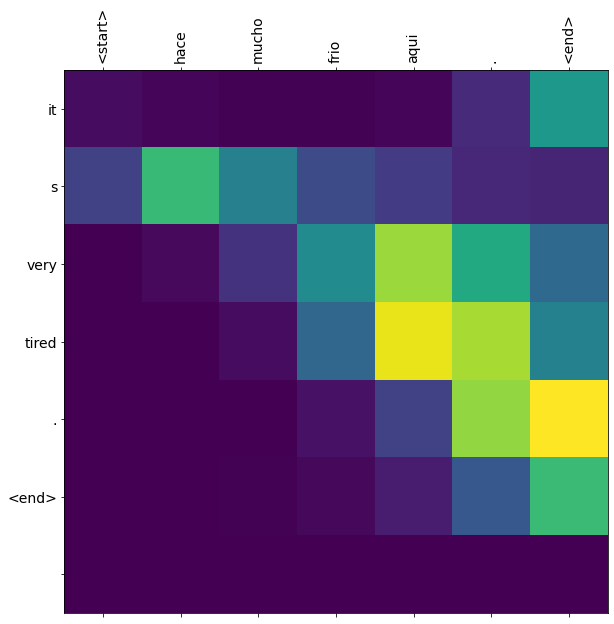

In [320]:
translate(u'hace mucho frio aqui.')